&copy; 2023-2025 Michał Bukowski (michal.bukowski@tuta.io, m.bukowski@uj.edu.pl) Department of Analytical Biochemistry, Faculty of Biochemistry, Biophysics and Biotechnology, Jagiellonian University, Krakow, Poland

Distributed under GPL-3.0 license

This is a Jupyter Python notebook for the [tblastn-genomes](https://github.com/michalbukowski/tblastn-genomes) pipeline output analysis and visualisation. It is a part of the [TAS-Drug repository](https://github.com/michalbukowski/tas-drug) and is associated with the following study:

Bukowski M, Banasik M, Chlebicka K, Bednarczyk K, Bonar E, Sokołowska D, Żądło T, Dubin G, Władyka B. _Analysis of co-occurrence of type II toxin–antitoxin systems and antibiotic resistance determinants in Staphylococcus aureus_. (2025) mSystems 0:e00957-24.
https://doi.org/10.1128/msystems.00957-24

---

In [1]:
# Do the neccessary imports
import numpy as np
import pandas as pd
from PIL import Image
from collections import defaultdict
from itertools import product
from lib.assembly import Assembly, Locus, Gene
from lib.functions import fetch_seqids, sf_10, hyper, calc_ratios,  \
                          unstack_ratios, final_filter, plot_ratios

# Display Matplotlib plots as they are saved to a file
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

# Create the output directory
! mkdir -p output

---
## 1. Search for TA systems, drug resistance determinants and their co-occurrence analysis

---

### 1.1. Pre-process translated BLAST results
In this step, a preliminary processing of translated BLAST search results is performed.
- Load results of [tblastn-genomes](https://github.com/michalbukowski/tblastn-genomes) pipeline to a DataFrame. In order to download the original input data from the study by [Bukowski et.al (2025)](placeholder), use the `get_input.sh` script provided in the same repository directly in directory where this notebooks is present (see the [repository manual](https://github.com/michalbukowski/tas-drug)). The files will be placed in the `input` directory.
- Once the data is loaded, inspect last two rows of the DataFrame with translated BLAST search results.

---

In [2]:
df_all = pd.read_csv('input/tblastn.tsv', sep='\t')
df_all.tail(2)

,assembly,qseqid,qstart,qend,qlen,sseqid,sstart,send,pident,ppos,evalue,qcovs
2064854,GCA_028536505.1,gb|AAV80464.1|ARO:3000565|tet(38),1,450,450,DANGZZ010000047.1,646,1995,99.778,1.0,0.000000e+00,1.0
2064855,GCA_028536505.1,gb|BAE15963.1|ARO:3002868|dfrG,1,165,165,DANGZZ010000048.1,835,1329,100.000,1.0,4.920000e-108,1.0


---
- Add a new column that will indicate the strand a protein query is matched to. If this is the minus strand, `sstart` &gt; `send`, then swap `sstart` and `send` so that `sstart` &lt; `send` for all rows. Creating a separate column that indicates the strand and keeping the match coordinates within genomic sequences sorted (`sstart` &lt; `send`) will help to analyse the data in further steps.
- Remove prefixes from CARD sequnce IDs to make them shorter and more intuitive.
- Sort the whole DataFrame in respect to `sseqid`, `sstart`, `send` in the dafault ascending manner.
- Reset the DataFrame index and inspect its last two rows.

---

In [3]:
df_proc = df_all.copy()
df_proc['strand'] = 1
df_proc.loc[df_proc['sstart'] > df_proc['send'], 'strand'] = -1
df_proc.loc[df_proc['sstart'] > df_proc['send'], ['sstart', 'send']] = df_proc.loc[df_proc['sstart'] > df_proc['send'], ['send', 'sstart']].to_numpy()
df_proc['qseqid'] = df_proc['qseqid'].str.rsplit('|', n=1).apply(lambda l: l[-1])
df_proc.sort_values(['sseqid', 'sstart', 'send'])
df_proc.reset_index(drop=True, inplace=True)
df_proc.tail(2)

,assembly,qseqid,qstart,qend,qlen,sseqid,sstart,send,pident,ppos,evalue,qcovs,strand
2064854,GCA_028536505.1,tet(38),1,450,450,DANGZZ010000047.1,646,1995,99.778,1.0,0.000000e+00,1.0,1
2064855,GCA_028536505.1,dfrG,1,165,165,DANGZZ010000048.1,835,1329,100.000,1.0,4.920000e-108,1.0,1


---
- Mind that [tblastn-genomes](https://github.com/michalbukowski/tblastn-genomes) pipeline filters by default the search results in respect to query coverage (`qcovs` &ge; 0.9) and sequence similarity (`ppos` &ge; 0.8).
- Save the pre-processed translated BLAST search results to a file.

---

In [4]:
df_proc.to_csv(
    'output/tblastn_preprocessed.tsv',
    index = False,
    sep   = '\t'
)

---
### 1.2. Split the pre-processed translated BLAST results into antitoxins, toxins and resistance determinants
In this step, the pre-processed translated BLAST search results are divided into three DataFrames, each holding information on matches of, respectively, antitoxins, toxins and drug resistance determinants (drugs).
- Load the preprocessed translated BLAST results.
- Inspect last two rows of the DataFrame.

---

In [5]:
df_proc = pd.read_csv('output/tblastn_preprocessed.tsv', sep='\t')
df_proc.tail(2)

,assembly,qseqid,qstart,qend,qlen,sseqid,sstart,send,pident,ppos,evalue,qcovs,strand
2064854,GCA_028536505.1,tet(38),1,450,450,DANGZZ010000047.1,646,1995,99.778,1.0,0.000000e+00,1.0,1
2064855,GCA_028536505.1,dfrG,1,165,165,DANGZZ010000048.1,835,1329,100.000,1.0,4.920000e-108,1.0,1


---
- Fetch sequence IDs from input query files that contains protein sequences of antitoxins, toxins and drug resistance determinants (obtained from [CARD](https://card.mcmaster.ca/)).
- Inspect first three sequence IDs from each set.

---

In [6]:
anti = fetch_seqids('input/antitoxins.faa')
tox  = fetch_seqids('input/toxins.faa')
drug = fetch_seqids('input/card.faa')

print(anti[:3], tox[:3], drug[:3], sep=', ')

['MazE-Sa', 'PemI-Sa1', 'PemI-Sa2'], ['MazF-Sa', 'PemK-Sa1', 'PemK-Sa2'], ['CblA-1', 'SHV-52', 'dfrF']


---
- Split the initial DataFrame into three separate.
- Reset the index and inspect last two rows of each new DataFrame.

---

In [7]:
df_anti = df_proc[ df_proc['qseqid'].isin(anti) ].reset_index(drop=True)
df_anti.tail(2)

,assembly,qseqid,qstart,qend,qlen,sseqid,sstart,send,pident,ppos,evalue,qcovs,strand
204576,GCA_027757745.1,YefM-Sa2,1,85,85,DAMMDW010000004.1,136026,136280,100.0,1.0,5.040000e-53,1.0,-1
204577,GCA_027757745.1,MazE-Sa,1,56,56,DAMMDW010000009.1,100762,100929,100.0,1.0,1.560000e-32,1.0,1


In [8]:
df_tox = df_proc[ df_proc['qseqid'].isin(tox) ].reset_index(drop=True)
df_tox.tail(2)

,assembly,qseqid,qstart,qend,qlen,sseqid,sstart,send,pident,ppos,evalue,qcovs,strand
201857,GCA_027977885.1,MazF-Sa,1,120,120,DAMUBP010000007.1,7200,7559,100.0,1.0,5.940000e-76,1.0,-1
201858,GCA_027977885.1,YoeB-Sa2,1,88,88,DAMUBP010000013.1,33309,33572,100.0,1.0,1.380000e-54,1.0,1


In [9]:
df_drug = df_proc[ df_proc['qseqid'].isin(drug) ].reset_index(drop=True)
df_drug.tail(2)

,assembly,qseqid,qstart,qend,qlen,sseqid,sstart,send,pident,ppos,evalue,qcovs,strand
1658417,GCA_028536505.1,tet(38),1,450,450,DANGZZ010000047.1,646,1995,99.778,1.0,0.000000e+00,1.0,1
1658418,GCA_028536505.1,dfrG,1,165,165,DANGZZ010000048.1,835,1329,100.000,1.0,4.920000e-108,1.0,1


---
### 1.3. Assign TA and drug resistance determinants loci to genomes (assemblies)
In this step, matches of antitoxins, toxins and drug resistance determinants will be assigned as genes (`Gene` objects) gathered in loci (`Locus` objects) that occur in genomes/assemblies (`Assembly` objects).
- The `gene_keys` are columns from the three DataFrames that are treated as a gene properties (`Gene` objects).
- For each assembly accession found in the search results create an empty `Assembly` object, gather these objects in a dictionary.
- Group antitoxin DataFrame by `sseqid` and `strand` to facilitate finding antitoxin/toxin pairs in further steps.

---

In [10]:
gene_keys  = 'qseqid sstart send qcovs ppos'.split()
assemblies = { asmid : Assembly(asmid) for asmid in df_proc['assembly'].unique() }
gb_anti    = df_anti.groupby('sseqid strand'.split(), sort=False)

---
- Search for toxin/antitoxin pairs (coded within 100 bp distance), and add them to assemblies as genes in loci as well as to a global list of all discovered TA systems (`all_tas`) as bare names.
- This search may take some time, a progress information will be provided.

---

In [11]:
all_tas = set()

for ind, row_tox in df_tox.iterrows():
    if ind%1000 == 0:
        print(f'\rTA searching {ind/df_tox.shape[0]*100:3.0f}%', end='')
    
    key = (row_tox['sseqid'], row_tox['strand'])
    if key not in gb_anti.groups:
        continue
    sub_anti = gb_anti.get_group(key)
    
    for _, row_anti in sub_anti.iterrows():
        dists = np.abs([row_anti['sstart'] - row_tox['send'], row_tox['sstart'] - row_anti['send']])
        dist  = dists.min()
        if   row_anti['send']   < row_tox['sstart'] and dist > 100:
            continue
        elif row_anti['sstart'] > row_tox['send']   and dist > 100:
            break
        else:
            anti  = Gene(*row_anti[gene_keys])
            tox   = Gene( *row_tox[gene_keys])
            locus = Locus(
                f'{row_anti["qseqid"]}/{row_tox["qseqid"]}',
                row_anti['sseqid'],
                row_anti['strand'],
                (anti, tox)
            )
            assemblies[row_tox['assembly']].tas.append(locus)
            all_tas.add(locus.name)
            break

print(f'\rTA searching 100%')
print(f'Found {len(all_tas)} TAs')

TA searching 100%
Found 19 TAs


---
- Search for drug resistance determinants and add them to assemblies as genes in loci as well as to a global list of all discovered determinants (`all_drugs`) as bare names.
- This search may take some time, a progress information will be provided.

---

In [12]:
all_drugs = set()

for ind, row_drug in df_drug.iterrows():
    if ind%10000 == 0:
        print(f'\rDrug searching {ind/df_drug.shape[0]*100:3.0f}%', end='')
    drug = Gene(*row_drug[gene_keys])
    locus = Locus(
        row_drug['qseqid'],
        row_drug['sseqid'],
        row_drug['strand'],
        (drug,)
    )
    assemblies[row_drug['assembly']].drugs.append(locus)
    all_drugs.add(locus.name)

print(f'\rDrug searching 100%')
print(f'Found {len(all_drugs)} drugs')

Drug searching 100%
Found 158 drugs


---
- Inspect the results by displaying the complete lists of found TA systems and drug resistance determinants names (sorted alphabetically).

---

In [13]:
print(', '.join(sorted(all_tas)))

DinJ/YafQ, Epsilon/Zeta, MazE-Sa/MazF-Sa, MazE-Sa2/FicDoc-Sa, MazE-Sepi2/FicDoc-Sepi2, PemI-Sa1/PemK-Sa1, PemI-Sa2/PemK-Sa2, PemI-Sa3/PemK-Sa3, PemI-Sa4/PemK-Sa4, PemI-Sa5/PemK-Sa5, PemI-Sa6/PemK-Sa6, PemI-Sagn/PemK-Sagn, PemI-Scap/PemK-Scap, PemI-Ssci/PemK-Ssci, PemI-Svit/PemK-Swar, PemI-Swar/PemK-Swar, PezTAnti/PezTTox, YefM-Sa1/YoeB-Sa1, YefM-Sa2/YoeB-Sa2


In [14]:
print(', '.join(sorted(all_drugs)))

AAC(3)-IId, AAC(6')-Im, AAC6_Ie_APH2_Ia, ANT(4')-Ib, ANT(6)-Ia, ANT(9)-Ia, APH(2'')-IIIa, APH(2'')-If, APH(3'')-Ib, APH(3')-IIIa, APH(3')-IIa, APH(3')-Ia, APH(6)-Id, AcrE, AcrF, Afab_ACT_CHL, Bsui_mprF, CRP, Ecol_catII, Efac_ACT_CHL, Efae_ACT_CHL, Erm(33), Erm(47), ErmA, ErmB, ErmC, ErmT, ErmX, FosB1, FosB4, FosB5, FosB6, FosBx1, FosD, FosM3, FosY, KPC-9, LEN-6, MecI_rep, OKP-B-12, OXA-36, OXA-653, OXA-919, OXA-924, OmpA, PC1_blaZ, QnrB69, QnrD1, SAT-4, Saur_FosB, Saur_LmrS, Saur_mupA_MUP, Saur_norA, Scoh_vga(E), Sint_ACT_CHL, Spyo_ErmA_MLSb, Ssui_ACT_CHL, TEM-192, TEM-229, TEM-237, TEM-243, TEM-7, TriC, aad(6), aadA, aadA27, abeS, apmA, arlR, arlS, bcrA, catA8, ceoB, cfrA, clbC, clcD, cmlA5, cmlA6, dfrA14, dfrA16, dfrA8, dfrC, dfrD, dfrF, dfrG, dfrK, emeA, fexA, fexB, fusB, fusC, kdpD, lnuA, lnuB, lnuG, lsaA, lsaB, lsaC, lsaE, mecA, mecC, mecC-type_BlaZ, mecI, mecR1, mef(D), mefH, mepA, mepR, mgrA, mphC, msrA, msrC, msrF, norA, norC, optrA, poxtA, pp_cat, qacA, qacB, qacE, qacEdelta1,

---
### 1.4. Find co-occurring TA/drug loci
In this step, information of co-occurrence of TA systems and drug resistance determinants will be collected.
- Create the dictionary `co_occur`, the keys of which will be TA system/drug resistance determinant pairs, and the values, the count of how many times they are found in the same genomes/assemblies.
- Gather the information on total number of TA systems and drug resistance determinants occurrences in all genomes/assemblies.
- This data processing may take some time, a progress information will be provided.

---

In [15]:
co_occur = {
    (ta_name, drug_name) : 0 for ta_name, drug_name
    in product(all_tas, all_drugs)
}
ta_count   = defaultdict(int)
drug_count = defaultdict(int)

asm_len = len(assemblies)
for i, asm in enumerate(assemblies.values()):
    if i%100 == 0:
        print(f'\rCo-localising TAs with drugs {i/asm_len*100:3.0f}%', end='')
        
    ta_names   = {   ta.name for ta   in asm.tas   }
    drug_names = { drug.name for drug in asm.drugs }
    
    for ta_name in ta_names:
        ta_count[ta_name] += 1
        for drug_name in drug_names:
            co_occur[(ta_name, drug_name)] += 1
            
    for drug_name in drug_names:
        drug_count[drug_name] += 1
        
print(f'\rCo-localising TAs with drugs 100%')

Co-localising TAs with drugs 100%


---
### 1.5. Save the information on TA and drug resistance determinants prevalence in a nice tabular format
In this step, a summary on TA systems and drug resistance determinants in all investigated genomes will be prepared and saved to a file.
- Load the complete list of the analysed genomes/assemblies accession numbers.
- Determine their number.
- Inspect first five accession numbers.

---

In [16]:
with open('input/genomes_list.txt') as f:
    asm_accs = f.read().rstrip().splitlines()
asm_count = len(asm_accs)
print(asm_count, ', '.join(asm_accs[:5]) + '...', sep=': ')

75919: GCA_903807735.1, GCA_028965745.1, GCA_000587615.1, GCA_027647585.1, GCA_026607055.1...


---
- Create an empty DataFrame with TA systems names as row indices and drug resistance determinants names as columns names.
- Pre-fill it with `0`s.
---

In [17]:
tas_count   = len(all_tas)
drugs_count = len(all_drugs)
dist_df = pd.DataFrame(
    np.zeros((asm_count, tas_count + drugs_count), dtype=int),
    index=sorted(asm_accs),
    columns=sorted(all_tas,   key=lambda name: ta_count[name],   reverse=True) +
            sorted(all_drugs, key=lambda name: drug_count[name], reverse=True)
)
dist_df.index.name = 'assembly'

---
- Iterate over genomes/assemblies created before and set values of proper DataFrame cells to `1`.
- Inspect first two rows of the DataFrame.

---

In [18]:
for i, (asm_acc, asm) in enumerate(assemblies.items()):
    if i%100 == 0:
        print(f'\rGenerating the summary... {i/asm_len*100:3.0f}%', end='')
    for locus in asm.tas + asm.drugs:
        dist_df.loc[asm_acc, locus.name] = 1
print(f'\nTotal number of genomes: {dist_df.shape[0]}')
dist_df.head(2)

Generating the summary... 100%
Total number of genomes: 75919


,MazE-Sa/MazF-Sa,YefM-Sa1/YoeB-Sa1,YefM-Sa2/YoeB-Sa2,MazE-Sepi2/FicDoc-Sepi2,Epsilon/Zeta,PemI-Sa1/PemK-Sa1,MazE-Sa2/FicDoc-Sa,PemI-Sagn/PemK-Sagn,PezTAnti/PezTTox,PemI-Swar/PemK-Swar,...,abeS,OKP-B-12,FosBx1,salA,OXA-36,dfrA8,rsmA,CRP,lsaC,TEM-243
assembly,,,,,,,,,,,,,,,,,,,,,
GCA_000009005.1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCA_000009585.1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---
- Save the resulting DataFrame, which contains the distribution information, to a file.

---

In [19]:
dist_df.to_csv('output/ta_drug_dist.tsv', index=True, sep='\t')

---
### 1.6. Gather the TA/drug search results pairwise in a DataFrame, calculate pval_10
In this step, a new DataFrame will be generated that describes all observed TA system (`ta`)/drug resistance determinant (`drug`) co-occurrence expressed as the number of genomes/assemblies the co-occurrence takes place (`corr`). Additionally, the total count of each element across all genomes will be gathered (respectively, in the `ta_count` and `drug_count` column), similarly the total count of all genomes (`tot`). Next, calculate the cumulative probability values `pval_10` (the values of the survival function of the hypergeometric distribution) to assess probabilities that elements of subsequent pairs would co-occur at least 10 time on a purely random basis. Finally, calculate the cumulative probability values `pval_hyper`(the values of the cumulative distribution or survival function of the hypergeometric distribution, whichever lower) for the observed number of co-occurrences. For details, see the documentation for `sf_10()` and `hyper()` functions.
- Create the new DataFrame.
- Using `sf_10()` and `hyper()` functions calculate, respectively `pval_10` and `pval_hyper` probabilities based on values of the `ta_count`, `drug_count`, `corr` and `tot` columns.
- Save the results to a file.
- Inspect last two rows of the new DataFrame.

---

In [20]:
fin_df = pd.DataFrame(columns='ta drug ta_count drug_count corr tot'.split())

for (ta_name, drug_name), count in co_occur.items():
    fin_df.loc[fin_df.shape[0]] = ta_name, drug_name, ta_count[ta_name], drug_count[drug_name], count, asm_count

fin_df['pval_10']     = fin_df.loc[:, 'ta_count drug_count tot'.split()].apply(lambda row: sf_10(*row), axis=1)
fin_df['pval_hyper']  = fin_df.loc[:, 'corr ta_count drug_count tot'.split()].apply(lambda row: hyper(*row), axis=1)

fin_df.sort_values('ta drug corr'.split(), inplace=True)
fin_df.reset_index(drop=True, inplace=True)
fin_df.to_csv('output/ta_drug_raw.tsv', index=None, sep='\t')
fin_df.tail(2)

,ta,drug,ta_count,drug_count,corr,tot,pval_10,pval_hyper
3000,YefM-Sa2/YoeB-Sa2,vgaC,57617,7,0,75919,0.0,-4.727791e-05
3001,YefM-Sa2/YoeB-Sa2,vgaE,57617,326,14,75919,1.0,-6.695057e-172


---
## 2. Analyse co-occurrence ratios and render the final visualisation
---

### 2.1. Reshape the ratio of ratios data into a matrix and generate a heatmap
In this step, the pairwise TA/drug DataFrame will be transformed in the following way:
- The `calc_ratios()` function will add to the `fin_df` DataFrame the `ratio` column, which is $log_2 \left ( \frac{[corr]/[ta\_count]}{[drug\_count]/[total]} \right )$ expressing the ratio of ratios: (the drug resistance determinants count in TA+ genomes to the total TA+ genomes count) to (the total drug resistance determinants count to the total genomes count). The DataFrame will be saved to a file.
- The `unstack_ratios()` functions will first zero `ratio` values that are lower than `ratio_th` or their corresponding `pval_10` is lower than `pval10_th`. Then, it will add the `color` column expressing color in blue (-1.0) to red (1.0) scale corresponding to the ratio values. Next, it will present both `ratio` and `color` as `ratio_df` and `color_df` DataFrames with TA systems names as the row index and drug resistance determinants as the columns index.
- A copy of `ratio_df` will be created with row index and column names extended by the count of corresponding genetic elements (for manual inspection purposes). Such modified DataFrame with ratios raw values will be saved to a file.
- Both `ratio_df` and `color_df` are then filtered to remove manually selected rows and columns as well as blank (all zeros) ones except those explicitly indicated to be kept. The filtered `ratio_df` will be saved to a file.
- The filtered `ratio_df` and `color_df` will be used to create the final visualisation with the function `plot_ratios()`, which will also use information on total TA/drug counts, the manually set maximal ratio value and alternative names for some of the genetic elements declared in `alt_names` dictionary.

---

In [21]:
ratio_max = 8.0
ratio_th  = 1.0
pval10_th = 0.99
adjust    = True

fin_df = pd.read_csv('output/ta_drug_raw.tsv', sep='\t')
fin_df = calc_ratios(fin_df)
fin_df.to_csv(f'output/ta_drug_ratios.tsv', sep='\t')
ratio_df, color_df, abs_max = unstack_ratios(fin_df, ta_count, drug_count, pval10_th, ratio_th, ratio_max, adjust)

print('Maximal absolute value of log2_ratio:', abs_max, end='\n\n')
display(ratio_df.head(2))
color_df.head(2)

Maximal absolute value of log2_ratio: 7.918010359305987



drug,norC,dfrC,mgrA,mepR,tet(38),Saur_norA,sepA,mepA,kdpD,sdrM,...,salA,Spyo_ErmA_MLSb,clbC,ceoB,abeS,aadA27,TriC,TEM-243,TEM-237,QnrD1
ta,,,,,,,,,,,,,,,,,,,,,
MazE-Sa/MazF-Sa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YefM-Sa1/YoeB-Sa1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


drug,norC,dfrC,mgrA,mepR,tet(38),Saur_norA,sepA,mepA,kdpD,sdrM,...,salA,Spyo_ErmA_MLSb,clbC,ceoB,abeS,aadA27,TriC,TEM-243,TEM-237,QnrD1
ta,,,,,,,,,,,,,,,,,,,,,
MazE-Sa/MazF-Sa,"[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]",...,"[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]"
YefM-Sa1/YoeB-Sa1,"[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]",...,"[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]"


In [22]:
filter_blank = True

ratio_copy_df = ratio_df.copy()
ratio_copy_df.index   = [ f'{ta_name} ({ta_count[ta_name]})'       for ta_name   in ratio_df.index   ]
ratio_copy_df.columns = [ f'{drug_name} ({drug_count[drug_name]})' for drug_name in ratio_df.columns ]

remove = ['MazE-Sa2/FicDoc-Sa', 'PemI-Sagn/PemK-Sagn', 'mecR1', 'mecI', 'MecI_rep', 'vgaALC', 'fexB']
keep   = ['MazE-Sa/MazF-Sa']

ratio_df = final_filter(ratio_df, remove, keep, filter_blank)
color_df = color_df.loc[ratio_df.index, ratio_df.columns].copy()
ratio_df.to_csv(f'output/final_ratios_{ratio_th:0.2f}.tsv', sep='\t')

display(ratio_df.head(2))
color_df.head(2)

drug,PC1_blaZ,mecA,Saur_FosB,ANT(9)-Ia,ErmA,APH(3')-IIIa,ANT(4')-Ib,ErmC,AAC6_Ie_APH2_Ia,msrA,...,ANT(6)-Ia,qacG,vgaA,Efac_ACT_CHL,vgaE,mecC-type_BlaZ,mecC,apmA,spd,cfrA
ta,,,,,,,,,,,,,,,,,,,,,
MazE-Sa/MazF-Sa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
YefM-Sa1/YoeB-Sa1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.19198,0.0,-2.985138,0.0,0.0,-4.336046,-3.513585,-1.405587


drug,PC1_blaZ,mecA,Saur_FosB,ANT(9)-Ia,ErmA,APH(3')-IIIa,ANT(4')-Ib,ErmC,AAC6_Ie_APH2_Ia,msrA,...,ANT(6)-Ia,qacG,vgaA,Efac_ACT_CHL,vgaE,mecC-type_BlaZ,mecC,apmA,spd,cfrA
ta,,,,,,,,,,,,,,,,,,,,,
MazE-Sa/MazF-Sa,"[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]",...,"[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]"
YefM-Sa1/YoeB-Sa1,"[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]",...,"[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[0.851002543139742, 0.851002543139742, 1.0]","[1.0, 1.0, 1.0]","[0.6268577556401633, 0.6268577556401633, 1.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[0.4579941889495811, 0.4579941889495811, 1.0]","[0.5608019157555577, 0.5608019157555577, 1.0]","[0.8243015722929465, 0.8243015722929465, 1.0]"


---
### 2.2. Rename TA/drug names for visualisation purposes
In this step, an optional dictionary is created that may serve for substituting original sequence IDs (names) for visualisation purposes.
- Create the `alt_names` dictionary to substitute original sequence IDs (names) for more suitable and standardised.

---

In [23]:
alt_names = {
    'PC1_blaZ'        : 'blaZ',
    'Saur_FosB'       : 'fosB',
    'ANT(9)-Ia'       : 'ant(9)-Ia',
    'ErmA'            : 'ermA',
    'APH(3\')-IIIa'   : 'aph(3\')-IIIa',
    'ANT(4\')-Ib'     : 'aadD2',
    'ErmC'            : 'ermC',
    'AAC6_Ie_APH2_Ia' : 'aacA-aphD',
    'SAT-4'           : 'sat-4',
    'Saur_mupA_MUP'   : 'ileS2',
    'ErmB'            : 'ermB',
    'ErmT'            : 'ermT',
    'ANT(6)-Ia'       : 'ant6',
    'Efac_ACT_CHL'    : 'efac_act_chl',
    'mecC-type_BlaZ'  : 'mecC-type_blaZ',
    
    'MazE-Sa/MazF-Sa'         : 'MazEF-Sa',
    'YefM-Sa1/YoeB-Sa1'       : 'YefM/YoeB-Sa1',
    'YefM-Sa2/YoeB-Sa2'       : 'YefM/YoeB-Sa2',
    'MazE-Sepi2/FicDoc-Sepi2' : 'MazE/FicDoc-Sepi2',
    'PemI-Sa1/PemK-Sa1'       : 'PemIK-Sa1'
}

---
### 2.3. Visualise the final TA/drug co-occurrence results
In this final step, the ratio of ratios data is plotted and the final figure saved to a file. For more details refer to the documentation of the `plot_ratios()` function.
- Adjust the figure width in inch. The height will be adjusted automatically to preserve proper width/height ratio for the colormap square grid.
- Adjust values of 8 remaining arguments that configure the padding of main and scale bar axes.
- Keep in mind that the color scale depends on the `ratio_max` value chosen in one of earlier steps.
- The `plot_ratios()` function returns references to the whole figure as well as to the colormap and scale bar axes.

---

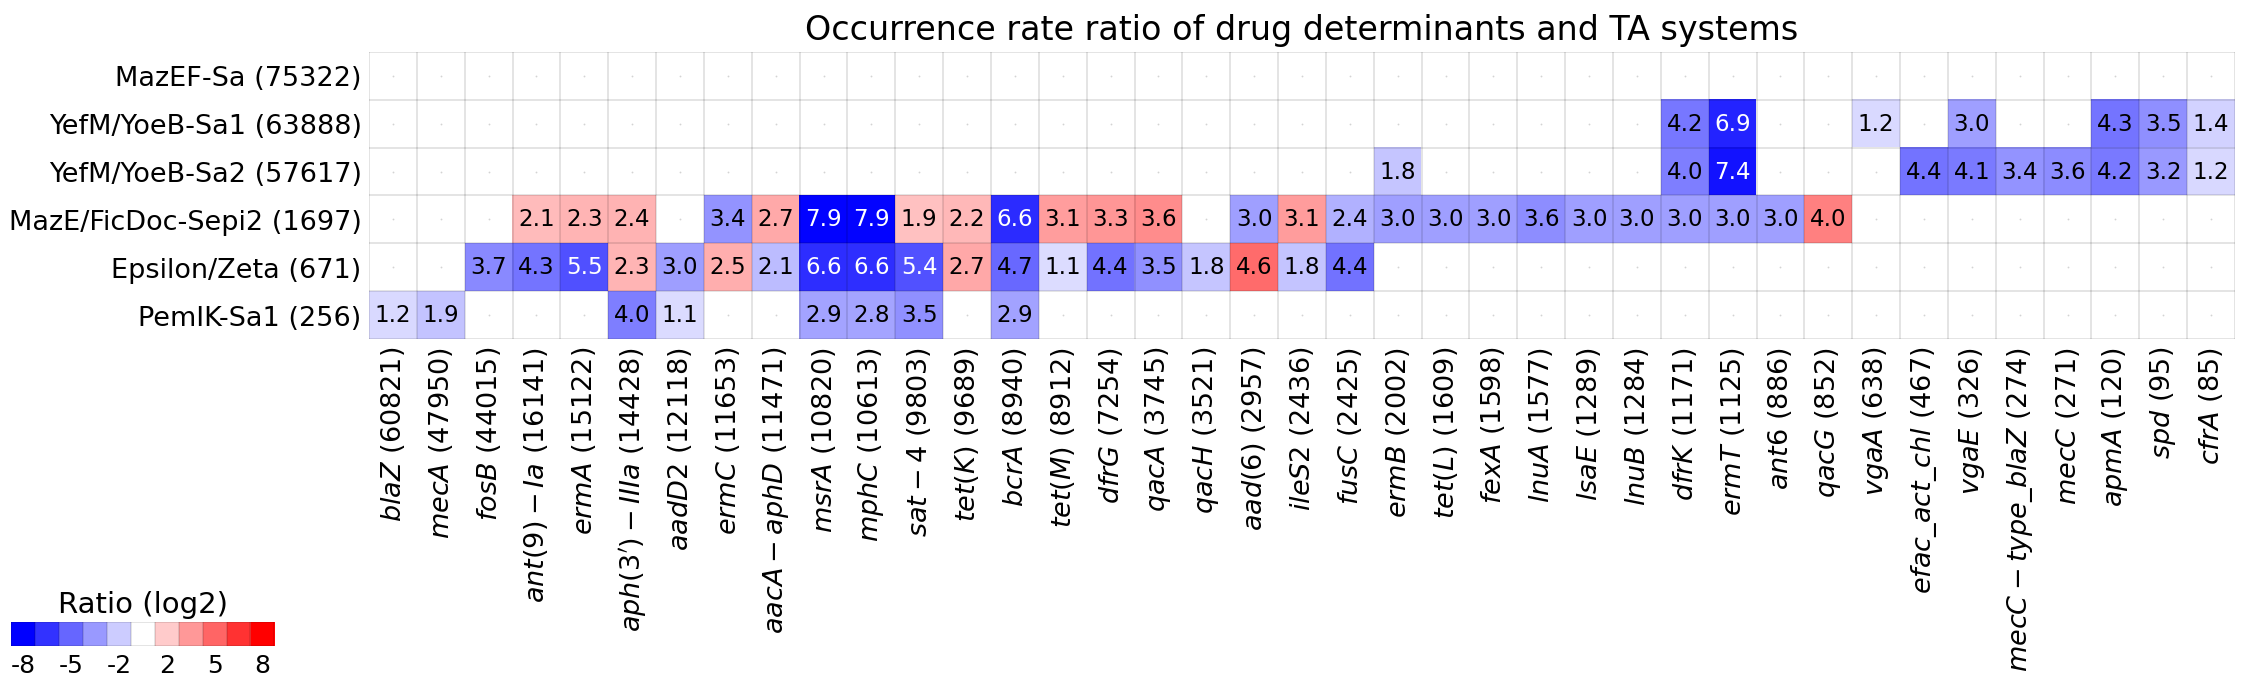

In [24]:
fig_width = 15.0

ax_left   = 2.46
ax_right  = 0.10
ax_top    = 0.35
ax_bottom = 2.30

bar_count  = 11
bar_scale  = 0.5
bar_left   = 0.005
bar_bottom = 0.055

fpath = f'output/final_ratios_{ratio_th:0.2f}.png'

fig, ax, bar_ax = plot_ratios(
    ratio_df, color_df, ta_count, drug_count, alt_names,
    fig_width, ax_left, ax_right, ax_top, ax_bottom,
    bar_count, bar_scale, bar_left, bar_bottom, ratio_max
)

fig.savefig(fpath, transparent=False, dpi=300)
Image.open(fpath).convert('RGB').save(fpath)